In [1]:

import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

num_gpus = torch.cuda.device_count()


c:\Users\adam\miniconda3\envs\torchgpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_gpus

0

# 1. Dataset Analysis

dataset url: https://www.kaggle.com/datasets/googleai/pfam-seed-random-split

I have locally saved the raw data in the folder data/random_split, it is partitioned into the three folds as per the initial dataset.

Definitions:
* Sequence: These are the Amino Acid sequences for each domain, which is a sub part of a protein. There are around 20 common amino acids and 4 uncommon ones.
* family_id/ family_accession: Labels for the model, containing the english words for the family and the Pfam ID.
* aligned_sequence: It's a sequence from the multiple sequence alignment - with gaps retained. 
* Sequence name: This is the name given to the sequence, form: "$uniprotaccessionid/$startindex-$end_index"

Reading this article on pfam and aligned sequences for context: https://academic.oup.com/nar/article/26/1/320/2379329
* pfam was established in 1998 was created as an organised database for protein domain families.

Dictionary:
* Domain: The structural and functional units of a protein, a proteins functionality come from their domains. A relatively (to the number of protein) low number of domains are used in a large # of proteins. Examples; solenoid, alpha alpha barrel, 3 layer sandwich (my personal favouritely named).

* Seed alignment - is a manually verified multiple alignment of a representative set of sequences, here's an example that made sense to me 
    * Example of a typical pfam entry, this is the SH2 family or PF00017
    * Dots and dashes represent identical and deleted amino acids, respectively


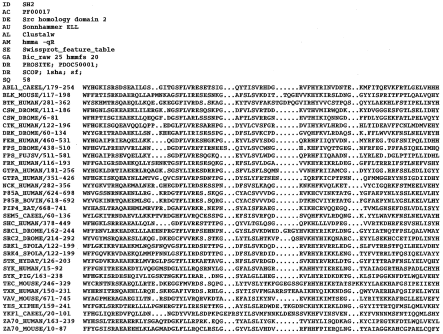

In [3]:
from IPython.display import Image
Image(filename='images/msa_example.gif', width=500, height=500) 

I have created a DatasetExplorer class which takes the three folds as inputs, as well as config for the various plots and displays.

Continuing work in this area, I would break this class down into subclasses for different areas of data exploration - e.g. a class specifically for family analysis, one for sequences and other important aspects of the data.

Looking at the data below, we can see there is 1m rows in train and approximately 100k in val/test.

In [4]:
import load_data as ld
import exploration as exp

loader = ld.DataLoader()
train_df, val_df, test_df = loader.load_all_three_dfs()

explorer = exp.DatasetExplorer(train_df, val_df, test_df, top_n_families=10)

explorer.print_n_rows_df()


Number of train rows: 1086741
Number of val rows: 126171
Number of test rows: 126171


The target variable is the family_accession or family_id which are equivalents.

Immediately we can see there are a large number of classes, with nearly 18000 unique families in train. Some of the families have a very large number of rows, others have very few. Hence we have a relatively imbalanced problem.

Something that we should be wary of in our analysis stage of our model is considering how the model does across families - i.e. using imbalanced metrics such as f1 score adjusted for multiclass. For example, a model that only predicts the most popular class would be right 3637 times as shown below.

In [5]:
explorer.family_summary_text()

There are 17929 unique families in train
There are 13071 unique families in test
There are 13071 unique families in val 
 

There are 0 new families in test vs train
There are 0 new families in val vs train 
 

Number of rows per family:
count   17929.000
mean       60.614
std       115.623
min         1.000
25%         8.000
50%        22.000
75%        65.000
max      3637.000
Name: family_accession, dtype: float64





One thing I noticed looking at the data is that there were duplicate sequences, and this is due to the below where the same sequence may be tagged under different sequence names. 

Upon further investigation, this is a minor issue but worth being aware of in case of any joins/issues with these families.

In [6]:
explorer.multiple_records_per_sequence()

There are 233 unique sequences, that have multiple family_ids 
There are 659 rows in total that have multiple family ids 

Here's an example:
                                               sequence         sequence_name
4713  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q75IE4_ORYSJ/406-474
709   GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2QSL1_ORYSJ/406-474
6381  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q84ME8_ORYSJ/406-474
2318  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2RAX6_ORYSJ/601-669
9685  GLFRFSLSDFCNKSVNHICGSVDDEANVWHSRLCHINFGLMSRLSS...  Q2QMW4_ORYSJ/891-959





## Sequence length 

A key factor in the dataset is the sequence length of each domain. This will be an important consideration for compute time and performance, as we may need to truncate the sequence lengths.

* We can see the Train, Test and Val broadly have similar distributions on the sequence length
* Sequence lengths 95 perentile is 380, hence if we need to truncate sequences - it will be impacting few if above this number



Sequence length percentiles: 
count   1086741.000
mean        155.380
std         120.123
min           4.000
5%           40.000
10%          52.000
50%         119.000
90%         308.000
95%         386.000
max        2037.000
Name: sequence_length, dtype: float64





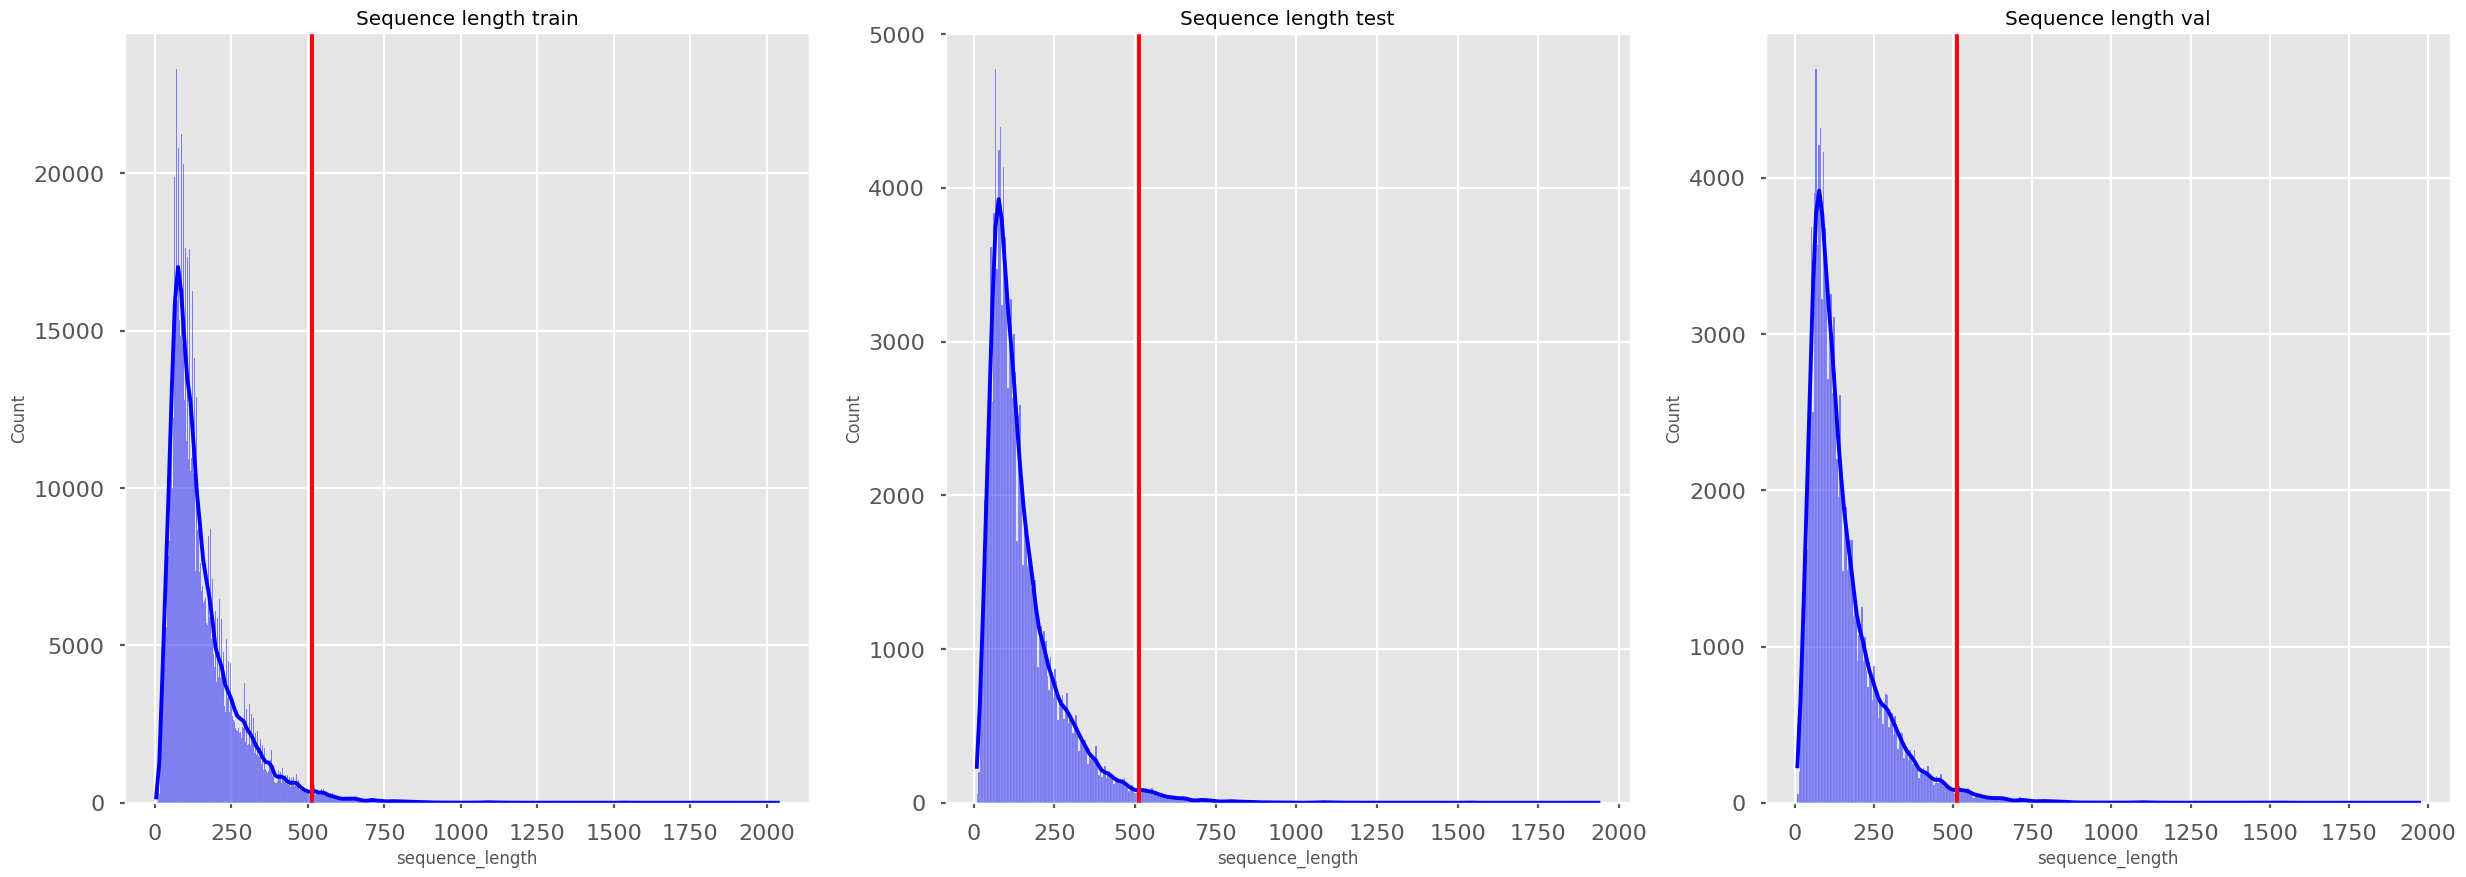

In [7]:
explorer.print_sequence_length_info()

# Major families sequence length and presence of letters

One immediate takeaway is that the major families are all relatively low in length, and there appears to be a relatively clear relationship between sequence length and family ID. Making it a likely very good indicator for modelling.

There are exceptions with Lipase_GDSL_2 being relatively spread out. 

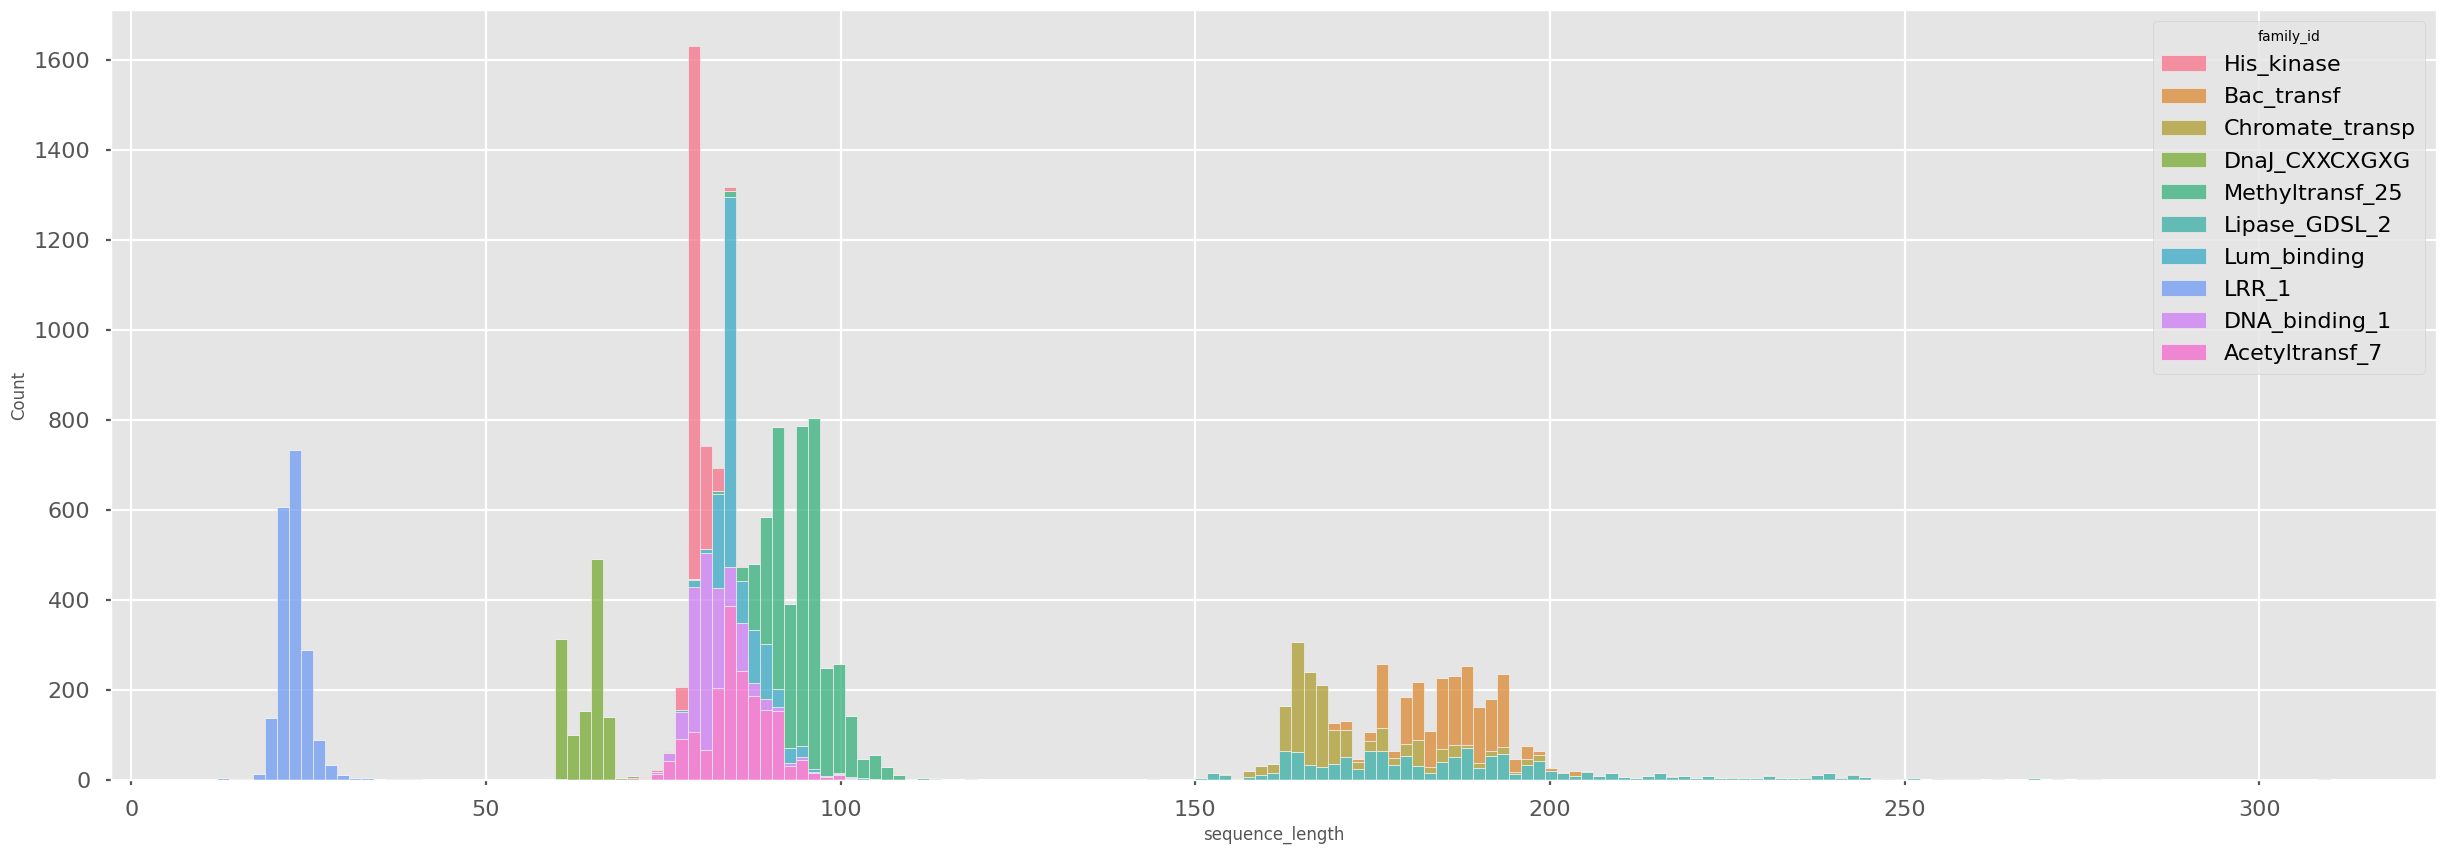

In [7]:
explorer.plot_major_families()

# Longest sequences

I then wanted to take a look at larger chains to understand how they might be impacted from truncation.

* We can see the phosphorylase group would be significantly impacted by truncating the sequence, along with FHIPEP - worth bearing this in mind if they get significantly misclassified with truncating sequence length.


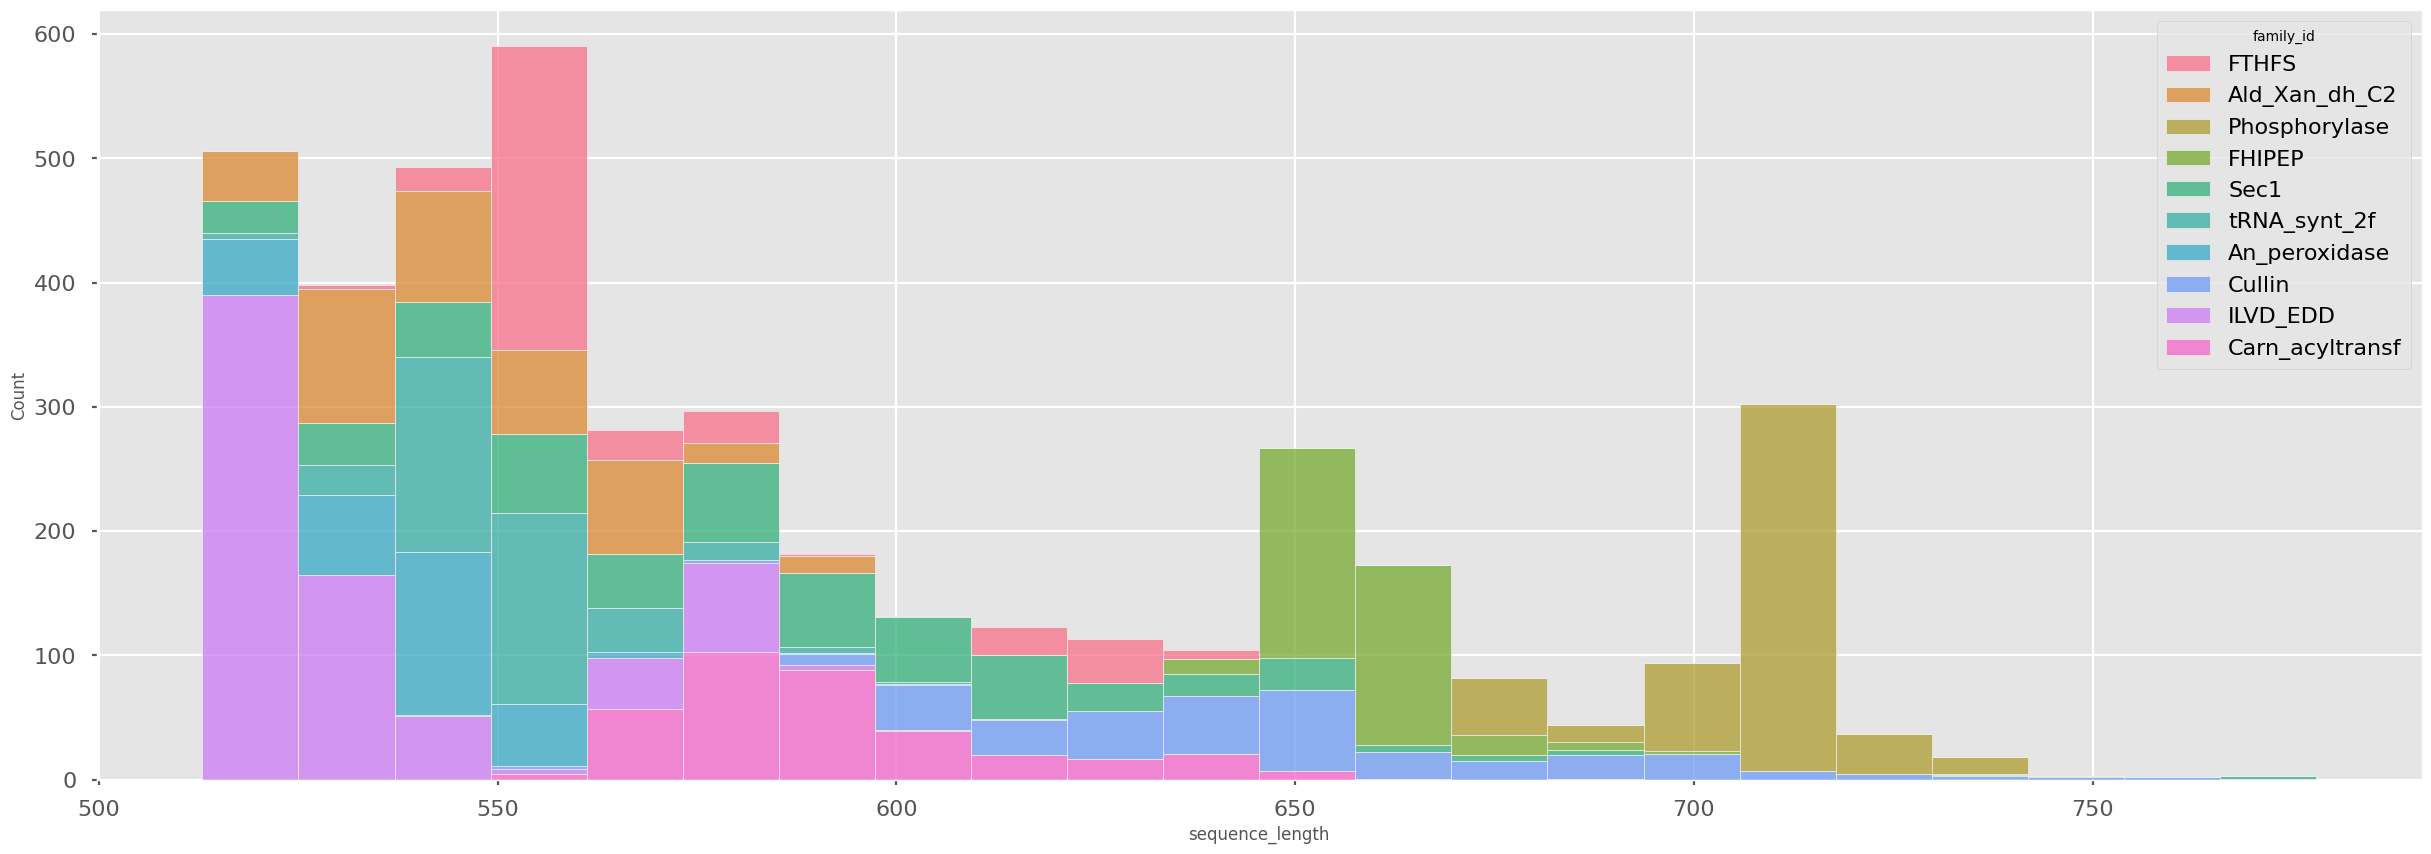

In [8]:
explorer.plot_major_families_above_threshold(length_cutoff=512)

# Amino Acids

One final point to understand was the amino acids composing of the chains. I have saved a text file containing all the acids.

In [9]:
with open("acids.txt") as f:
    acids = list(f.read())
    
rare_acids = ['X', 'U', 'B', 'O','Z']

## Rare acids

An example 

The globins are a superfamily of heme-containing globular proteins, involved in binding and/or transporting oxygen.

In [10]:
train_df[train_df['sequence'].apply(lambda x: 'Z' in list(set(x)))]

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
6398,Baculo_p74,Q6JPC1_NPVNC/339-551,PF04583.12,IILEFFNE...FPILSSILIDLGYTVIDELYTRIMKKIIT.KTIPY...,IILEFFNEFPILSSILIDLGYTVIDELYTRIMKKIITKTIPYIEKF...,213
518,Globin,HBB_LITCT/1-105,PF00042.22,GGSDVSAFLAK.V........DKRAVGGEALARLLIVYPWTQRYFS...,GGSDVSAFLAKVDKRAVGGEALARLLIVYPWTQRYFSTFGNLGSAD...,105
712,Globin,HBBN_AMMLE/2-106,PF00042.22,BKALITGFWSK.V........KVBZVGAZALGRLLVVYPWTZRFFZ...,BKALITGFWSKVKVBZVGAZALGRLLVVYPWTZRFFZHFGBLSSAB...,105


In [13]:
train_df[train_df['sequence'].apply(lambda x: 'O' in list(set(x)))].head(5)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
144,Dimeth_Pyl,D9QQJ6_ACEAZ/6-459,PF09505.10,...QTRLGDGSTIEMTEDEIRADIERGIEDAVDRAEVDSLPEEEIE...,QTRLGDGSTIEMTEDEIRADIERGIEDAVDRAEVDSLPEEEIEKLT...,454
10217,Dimeth_Pyl,M4YJT7_THEXX/1-456,PF09505.10,......MGDGRTVYMTRENVLEDIRKGMADAADAAGVPDLNENEIE...,MGDGRTVYMTRENVLEDIRKGMADAADAAGVPDLNENEIEQMADVI...,456
5576,MtmB,U5Q555_METII/7-453,PF05369.12,.SIYDTYERFLKGQKVAESDWDYVTIPTNATAMKEKYNIKF.G.KE...,SIYDTYERFLKGQKVAESDWDYVTIPTNATAMKEKYNIKFGKEIIP...,447
10348,Dimeth_Pyl,U5Q2B5_METII/2-463,PF09505.10,AEYPIRRGDGKRLYLSRQQILDDINEGIADAADIASVPNLTSDDID...,AEYPIRRGDGKRLYLSRQQILDDINEGIADAADIASVPNLTSDDID...,462
9461,MtmB,D9QRT3_ACEAZ/7-457,PF05369.12,VDVFEAYNRALTGPKVDKDEWDYEVIPENAKKMKEKYDIEF.EEGE...,VDVFEAYNRALTGPKVDKDEWDYEVIPENAKKMKEKYDIEFEEGEF...,451


In [14]:
train_df[train_df['sequence'].apply(lambda x: 'B' in list(set(x)))].head(5)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,sequence_length
518,Globin,HBB_LITCT/1-105,PF00042.22,GGSDVSAFLAK.V........DKRAVGGEALARLLIVYPWTQRYFS...,GGSDVSAFLAKVDKRAVGGEALARLLIVYPWTQRYFSTFGNLGSAD...,105
2198,Kunitz_BPTI,IBPC_BOVIN/7-59,PF00014.23,LCQLPQ.ARG..P.CK...A......AL...LRYFYN....STSNA...,LCQLPQARGPCKAALLRYFYNSTSNACEPFTYGGCQGNNBNFETTE...,53
3126,gag_pre-integrs,A5B8R6_VITVI/39-107,PF13976.6,GLYHL..ES..........S....Q.K...T.S...........N....,GLYHLESSQKTSNNLSXSFLSSSNKDTIWLYHLRLGHPSFRVLKVX...,69
4384,gag_pre-integrs,A5AIR1_VITVI/152-227,PF13976.6,KLYKL..NIKAT....NGNE....T.L...H.S...........S....,KLYKLNIKATNGNETLHSSNYGIKRKLINENSSMLWHRRLDHISNQ...,76
1531,YcaO,Y1265_HAEIN/60-392,PF02624.16,NGKGA.SKKAALASALGEYFERL..S........TN......YFFA...,NGKGASKKAALASALGEYFERLSTNYFFADFYLGQEIANSDFVHYP...,333


# 2 - Method Explanation

## Embeddings

I focused on looking at generating various models using a combination of simple feature extractions and pretrained language models. 

Reading this paper as a helpful reference: "An Analysis of Protein Language Model Embeddings for Fold Prediction" [https://www.biorxiv.org/content/10.1101/2022.02.07.479394v1.full], some key takeaways from me:

Major models mentioned:
* ESM-1B, ESM-MSA, ProtBERT, Prott5, UniRep and Seqvec
* They found strong performance from ProtBERT, prott5 and the ESM models. 
* It is also worth noting that since that paper ESM have released the esm-2 models.

I used the bio-transformers library developed by your company, and forked a copy with key modules. This was partially in case of needing to adjust the wrapper for TransformersWrapper and also for dependancy management, the environment I created uses some components of bio-transformers but not all.  

Other models mentioned in this space: 
* ProtCNN from original release of dataset - https://storage.googleapis.com/pub-tools-public-publication-data/pdf/d2bf7f5a486fd3b8e2f29339660a0b39f50d21b4.pdf

The goal of each pre-trained model is to provide embeddings or to directly extend the model, for example adding more layers. For simplicity and time, I have opted for the first option. 

Another consideration is compute, some models may have millions/billions of parameters

https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf - esm2 vs esm1 



In [9]:
import embedder_transformer as et 
import imp
imp.reload(et)
transformer = et.EmbedderTransformer(train_size=1000, val_size=1000, test_size=1000, num_gpus=num_gpus)

In [12]:
transformer.embed_and_unload('pct_embedder')

Using bio-transformers embedder


  1%|          | 10/1000 [00:03<06:03,  2.72it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\adam\AppData\Local\Temp\ipykernel_18336\3253602441.py:1 in <module>                     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\adam\\AppData\\Local\\Temp\\ipykernel_18336\\3253602441.py'                          │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\embedder_transformer.py:35 in embed_and_unload                      │
│                                                                                                  │
│   32 │   │   return train_embeddings_df, val_embeddings_df, test_embeddings_df                   │
│   33 │                                                                                           │
│   34 │   def embed_and_unload(self, embedder_name):                                              │
│ ❱ 35 │   │   embed_train, embed_test, embed_val = self.embed_input_sequences()                   │
│   36 │   │   path = 'embeddings/' + str(embedder_name) + '/'                                     │
│   37 │   │   os.makedirs(path)                                                                   │
│   38                                                                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\embedder_transformer.py:28 in embed_input_sequences                 │
│                                                                                                  │
│   25 │   │   else:                                                                               │
│   26 │   │   │   raise Exception('No correct embedder')                                          │
│   27 │   │                                                                                       │
│ ❱ 28 │   │   train_embeddings_df = embedder.embed_sequences(self.train_df)                       │
│   29 │   │   val_embeddings_df = embedder.embed_sequences(self.val_df)                           │
│   30 │   │   test_embeddings_df = embedder.embed_sequences(self.test_df)                         │
│   31                                                                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\pretrained_embedder.py:21 in embed_sequences                        │
│                                                                                                  │
│   18 │   │   │   lambda x: x[0 : self.sequence_length + 1]                                       │
│   19 │   │   )                                                                                   │
│   20 │   │   sequences = np.array(sequences_truncated.values)                                    │
│ ❱ 21 │   │   esm_embed_arrays = self.transformer.compute_embeddings(sequences)["cls"]            │
│   22 │   │   return self.join_embeddings_to_df(esm_embed_arrays, input_df)                       │
│   23 │                                                                                           │
│   24 │   def set_transformer(self, model_name: str):                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\biotransformers\wrappers\transformers_wrappers.py:723 in            │
│ compute_embeddings                                                                               │
│                                                                                                  │
│   720 │   │   # Compute a forward pass to get the embedding

In [11]:
transformer.embed_and_unload('esm1_t6_43M_UR50S')

Using bio-transformers embedder


 12%|█▎        | 125/1000 [00:45<05:17,  2.76it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\adam\AppData\Local\Temp\ipykernel_18336\463366405.py:1 in <module>                      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\adam\\AppData\\Local\\Temp\\ipykernel_18336\\463366405.py'                           │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\embedder_transformer.py:35 in embed_and_unload                      │
│                                                                                                  │
│   32 │   │   return train_embeddings_df, val_embeddings_df, test_embeddings_df                   │
│   33 │                                                                                           │
│   34 │   def embed_and_unload(self, embedder_name):                                              │
│ ❱ 35 │   │   embed_train, embed_test, embed_val = self.embed_input_sequences()                   │
│   36 │   │   path = 'embeddings/' + str(embedder_name) + '/'                                     │
│   37 │   │   os.makedirs(path)                                                                   │
│   38                                                                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\embedder_transformer.py:28 in embed_input_sequences                 │
│                                                                                                  │
│   25 │   │   else:                                                                               │
│   26 │   │   │   raise Exception('No correct embedder')                                          │
│   27 │   │                                                                                       │
│ ❱ 28 │   │   train_embeddings_df = embedder.embed_sequences(self.train_df)                       │
│   29 │   │   val_embeddings_df = embedder.embed_sequences(self.val_df)                           │
│   30 │   │   test_embeddings_df = embedder.embed_sequences(self.test_df)                         │
│   31                                                                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\pretrained_embedder.py:21 in embed_sequences                        │
│                                                                                                  │
│   18 │   │   │   lambda x: x[0 : self.sequence_length + 1]                                       │
│   19 │   │   )                                                                                   │
│   20 │   │   sequences = np.array(sequences_truncated.values)                                    │
│ ❱ 21 │   │   esm_embed_arrays = self.transformer.compute_embeddings(sequences)["cls"]            │
│   22 │   │   return self.join_embeddings_to_df(esm_embed_arrays, input_df)                       │
│   23 │                                                                                           │
│   24 │   def set_transformer(self, model_name: str):                                             │
│                                                                                                  │
│ c:\Users\adam\pfam\pfam\data\biotransformers\wrappers\transformers_wrappers.py:723 in            │
│ compute_embeddings                                                                               │
│                                                                                                  │
│   720 │   │   # Compute a forward pass to get the embedding

In [ ]:
transformer.embed_and_unload('protbert')

## Modelling

Take in embedding features and provide a model, the general libraries that perform pretty well at the moment are lightgbm and autogluon. Since we have time on a GPU, I have opted to use autogluon, which implicitly uses lightgbm. I usually use lightgbm when in a bit of a rush.

In [110]:
import train_model as tm
import imp
imp.reload(tm)
embeddings_to_use = ["pct_embedder", "esm1_t6_43M_UR50S"]
model = tm.TrainModel(embeddings_to_use = embeddings_to_use)
dict_of_features, train_features, val_features, test_features = model.load_data()

In [111]:
import t_sne
import imp
imp.reload(t_sne)

<module 't_sne' from 'c:\\Users\\adam\\pfam\\pfam\\data\\t_sne.py'>

c:\Users\adam\miniconda3\envs\torchgpu\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


NameError: name 'i' is not defined

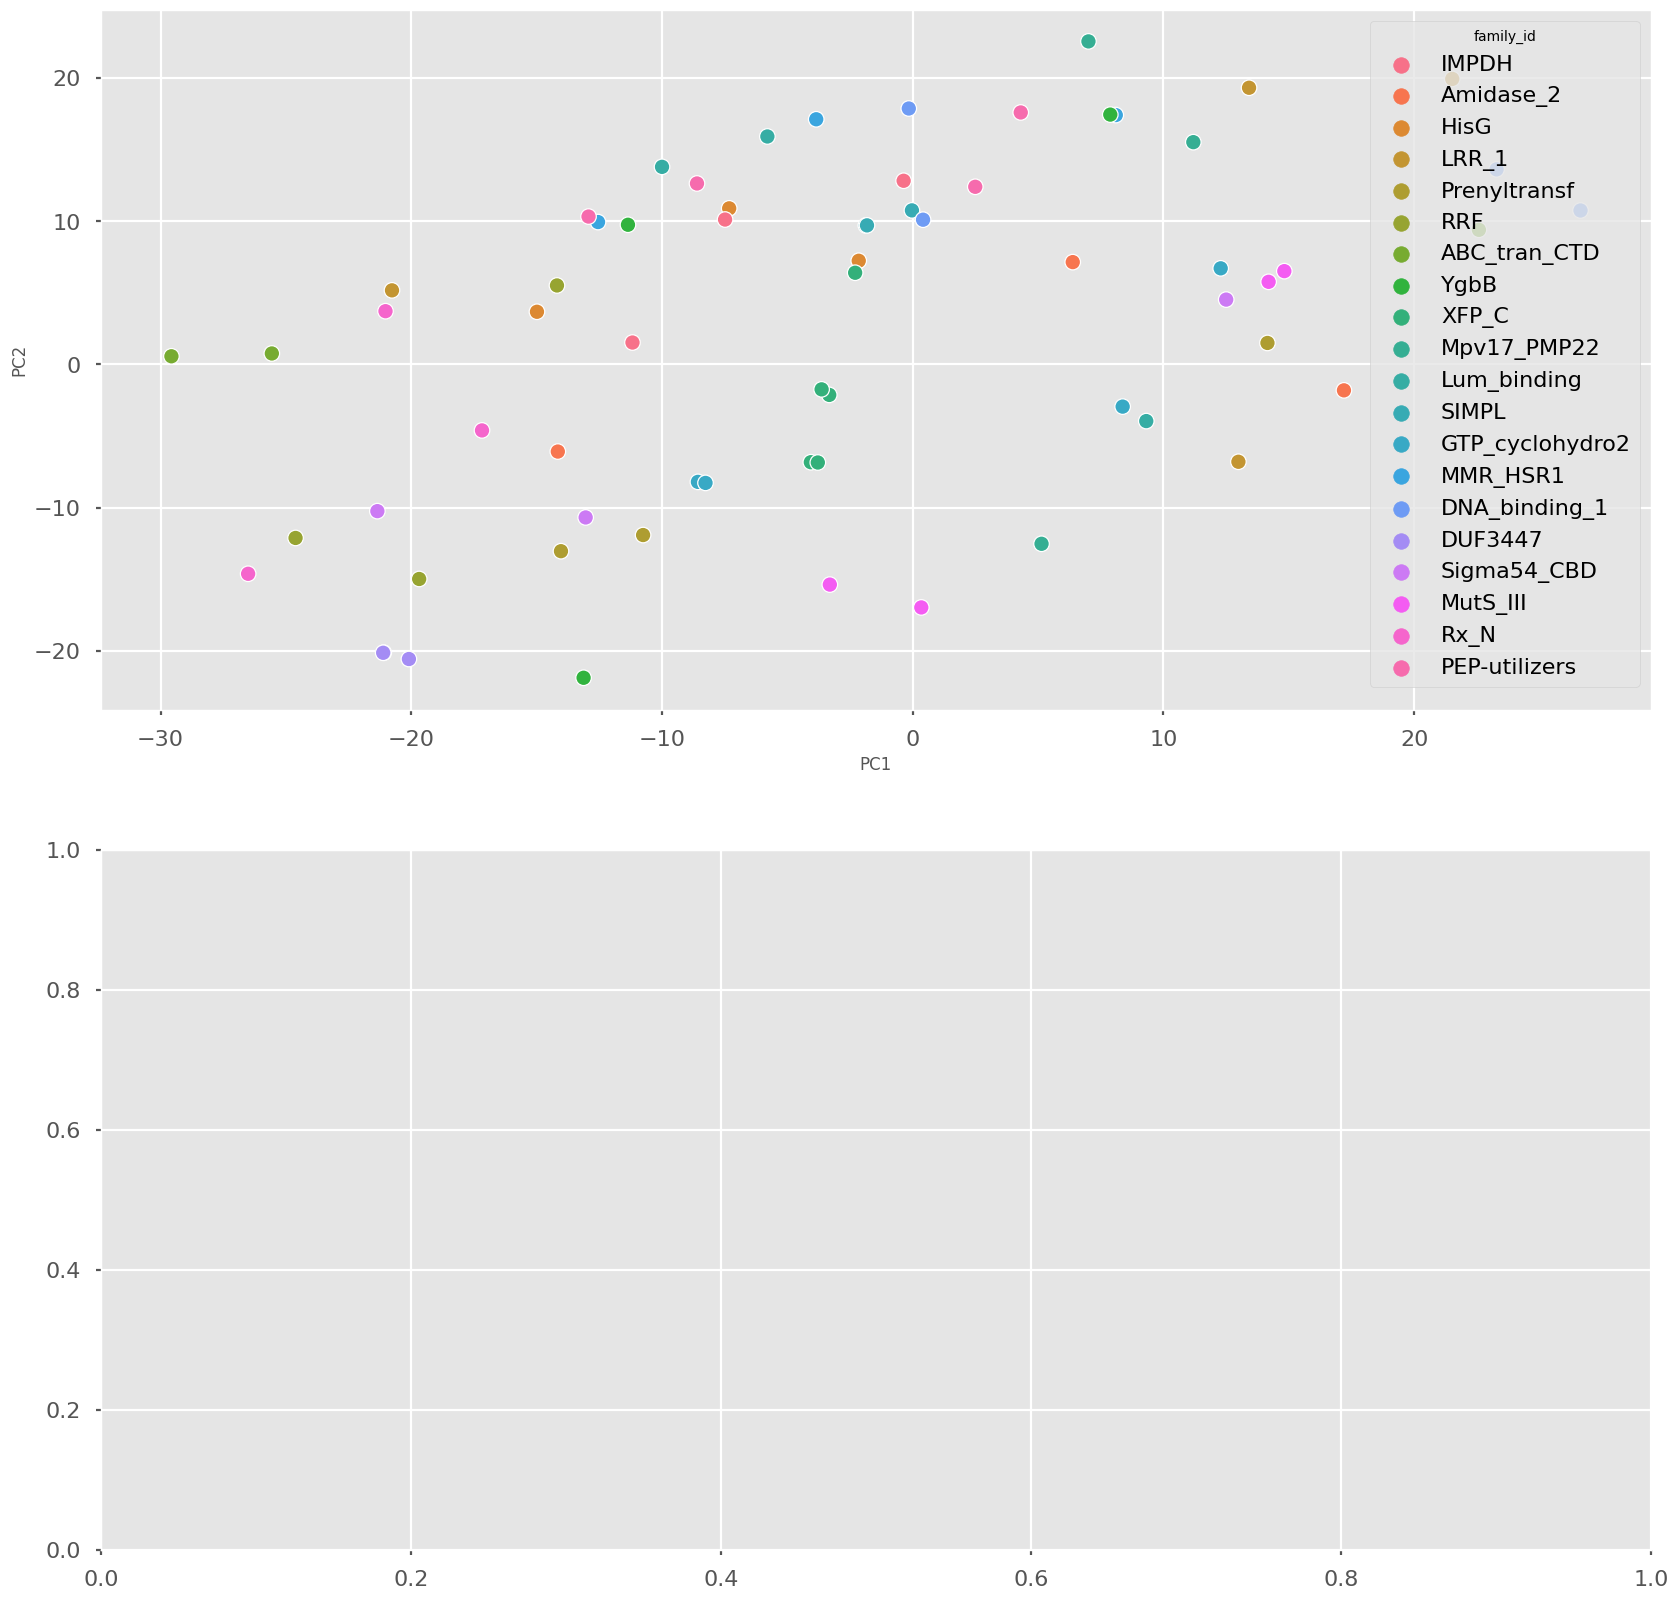

In [112]:
t_sne.plot_all_embeddings(train_features, embeddings_to_use, dict_of_features)

In [12]:
dict_of_dfs['pct_embedder'][0]

,sequence,family_id,C,D,T,E,N,X,Y,L,...,V,S,A,I,H,F,B,G,O,M
0,SAKRRLYSLIQNATEPYAFEPDLAVNLDIADLINQTGGNLPREAAF...,VHS,0.020690,0.055172,0.027586,0.062069,0.068966,0.0,0.041379,0.131034,...,0.055172,0.041379,0.082759,0.075862,0.006897,0.041379,0.0,0.034483,0.0,0.013793
1,LDLCIEEINRSIESISTLYFKPPGIFHNAVVHDQQGRGYSSIITKL...,DASH_Spc34,0.007299,0.062044,0.021898,0.105839,0.047445,0.0,0.032847,0.109489,...,0.058394,0.083942,0.036496,0.072993,0.043796,0.032847,0.0,0.047445,0.0,0.014599
2,AELKVLQAQIHPHFLFNALNTISSLIRTRPEKARELLAKLASFFRY...,His_kinase,0.000000,0.037975,0.025316,0.088608,0.050633,0.0,0.025316,0.164557,...,0.025316,0.063291,0.126582,0.063291,0.037975,0.063291,0.0,0.012658,0.0,0.000000
3,KCLDILYVAIQSIRVLTPTLRSLMYLVLNSLDHPHDSVHILALKTL...,Cnd3,0.036066,0.052459,0.052459,0.059016,0.062295,0.0,0.039344,0.147541,...,0.049180,0.075410,0.049180,0.098361,0.026230,0.042623,0.0,0.026230,0.0,0.016393
4,SCVQYTSCELCLGSRDPHCGWCVLHSICSRQDACERAEEPQRFASD...,PSI,0.156863,0.058824,0.019608,0.078431,0.000000,0.0,0.019608,0.098039,...,0.058824,0.117647,0.058824,0.019608,0.039216,0.019608,0.0,0.039216,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,LIGDLLPPGGLAVLVVPIDLQAPKGRLILPQVQTIRDALDNDAATL...,HydF_dimer,0.020202,0.080808,0.060606,0.020202,0.020202,0.0,0.030303,0.151515,...,0.111111,0.030303,0.090909,0.060606,0.000000,0.020202,0.0,0.050505,0.0,0.020202
996,ELVEVDLSGNYFSEEAMEEICNV,LRR_1,0.043478,0.043478,0.000000,0.260870,0.086957,0.0,0.043478,0.086957,...,0.130435,0.086957,0.043478,0.043478,0.000000,0.043478,0.0,0.043478,0.0,0.043478
997,ATTHVVVGGAGASIYDSKFTTSNINWSYYRDFDYGFVKLTALNRSS...,Metallophos_C,0.000000,0.080645,0.080645,0.016129,0.064516,0.0,0.096774,0.064516,...,0.080645,0.129032,0.064516,0.032258,0.032258,0.064516,0.0,0.080645,0.0,0.000000
998,MAPNATIFKALLHIADVDRHYYDDHTVTLARHPSETDERMMVRLLA...,YaeQ,0.017241,0.057471,0.051724,0.074713,0.034483,0.0,0.022989,0.132184,...,0.051724,0.028736,0.126437,0.040230,0.040230,0.022989,0.0,0.068966,0.0,0.034483


In [11]:
dict_of_dfs['esm1_t6_43M_UR50S'][0]

,sequence,family_id,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,SAKRRLYSLIQNATEPYAFEPDLAVNLDIADLINQTGGNLPREAAF...,VHS,0.411747,2.318271,2.557669,1.984419,3.422829,3.438028,0.146146,-1.479305,...,1.227051,-2.064951,0.285502,-0.433650,-0.866221,-3.063028,-6.520980,-0.791332,0.073158,-1.135263
1,LDLCIEEINRSIESISTLYFKPPGIFHNAVVHDQQGRGYSSIITKL...,DASH_Spc34,0.438202,2.136831,2.044946,2.835667,3.009153,3.415936,-0.072944,-1.150518,...,1.373812,-2.278514,0.343129,-0.684689,0.002041,-3.037342,-6.797785,-0.957314,-0.205315,-0.527026
2,AELKVLQAQIHPHFLFNALNTISSLIRTRPEKARELLAKLASFFRY...,His_kinase,1.142450,1.608033,2.595383,2.769110,3.535463,3.217193,0.186437,-1.149086,...,0.296660,-2.490786,-0.100685,-1.084100,-1.561476,-2.783539,-6.221028,-0.974715,0.193290,-0.885783
3,KCLDILYVAIQSIRVLTPTLRSLMYLVLNSLDHPHDSVHILALKTL...,Cnd3,0.067176,1.900917,2.088008,2.523884,3.481311,3.290255,0.566937,-1.209632,...,1.216559,-1.999029,0.637843,-0.757467,-0.654213,-3.061255,-6.768149,-0.526189,-0.475542,-0.467154
4,SCVQYTSCELCLGSRDPHCGWCVLHSICSRQDACERAEEPQRFASD...,PSI,0.289804,1.172529,1.636617,1.933111,2.161487,3.183502,-0.720039,-1.559550,...,0.545333,-3.333087,-0.063572,-1.355025,-0.459276,-2.835380,-5.977273,-0.665303,-0.046333,-1.693811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,LIGDLLPPGGLAVLVVPIDLQAPKGRLILPQVQTIRDALDNDAATL...,HydF_dimer,0.440236,2.136086,1.868736,2.030260,3.146793,3.326094,0.098827,-1.462024,...,1.185639,-2.864188,0.553926,-1.028405,-0.653700,-2.735924,-6.670179,-0.342362,-0.234893,-1.195701
996,ELVEVDLSGNYFSEEAMEEICNV,LRR_1,0.976634,1.557294,1.481551,2.550703,2.718905,2.846791,0.045542,-1.194199,...,0.639150,-2.583778,1.062480,-0.900757,-1.255102,-2.639547,-5.466391,-0.605522,-0.445488,-0.581155
997,ATTHVVVGGAGASIYDSKFTTSNINWSYYRDFDYGFVKLTALNRSS...,Metallophos_C,0.946843,1.512706,1.440292,2.209261,2.807732,3.359580,0.462701,-1.031267,...,1.176543,-2.321193,0.837774,-0.714785,-0.703649,-2.689928,-7.050312,-0.229926,0.115303,-1.515134
998,MAPNATIFKALLHIADVDRHYYDDHTVTLARHPSETDERMMVRLLA...,YaeQ,0.638250,2.131117,2.252722,2.496015,3.217183,3.113934,0.546491,-0.675757,...,0.812422,-2.329273,0.428825,-1.117984,-0.569965,-3.147671,-6.354263,-0.619395,-0.130024,-0.812645


In [15]:
pd.merge(dict_of_dfs['pct_embedder'][0], dict_of_dfs['esm1_t6_43M_UR50S'][0], on='sequence')

,sequence,family_id_x,C,D,T,E,N,X,Y,L,...,758,759,760,761,762,763,764,765,766,767
0,SAKRRLYSLIQNATEPYAFEPDLAVNLDIADLINQTGGNLPREAAF...,VHS,0.020690,0.055172,0.027586,0.062069,0.068966,0.0,0.041379,0.131034,...,1.227051,-2.064951,0.285502,-0.433650,-0.866221,-3.063028,-6.520980,-0.791332,0.073158,-1.135263
1,LDLCIEEINRSIESISTLYFKPPGIFHNAVVHDQQGRGYSSIITKL...,DASH_Spc34,0.007299,0.062044,0.021898,0.105839,0.047445,0.0,0.032847,0.109489,...,1.373812,-2.278514,0.343129,-0.684689,0.002041,-3.037342,-6.797785,-0.957314,-0.205315,-0.527026
2,AELKVLQAQIHPHFLFNALNTISSLIRTRPEKARELLAKLASFFRY...,His_kinase,0.000000,0.037975,0.025316,0.088608,0.050633,0.0,0.025316,0.164557,...,0.296660,-2.490786,-0.100685,-1.084100,-1.561476,-2.783539,-6.221028,-0.974715,0.193290,-0.885783
3,KCLDILYVAIQSIRVLTPTLRSLMYLVLNSLDHPHDSVHILALKTL...,Cnd3,0.036066,0.052459,0.052459,0.059016,0.062295,0.0,0.039344,0.147541,...,1.216559,-1.999029,0.637843,-0.757467,-0.654213,-3.061255,-6.768149,-0.526189,-0.475542,-0.467154
4,SCVQYTSCELCLGSRDPHCGWCVLHSICSRQDACERAEEPQRFASD...,PSI,0.156863,0.058824,0.019608,0.078431,0.000000,0.0,0.019608,0.098039,...,0.545333,-3.333087,-0.063572,-1.355025,-0.459276,-2.835380,-5.977273,-0.665303,-0.046333,-1.693811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,LIGDLLPPGGLAVLVVPIDLQAPKGRLILPQVQTIRDALDNDAATL...,HydF_dimer,0.020202,0.080808,0.060606,0.020202,0.020202,0.0,0.030303,0.151515,...,1.185639,-2.864188,0.553926,-1.028405,-0.653700,-2.735924,-6.670179,-0.342362,-0.234893,-1.195701
996,ELVEVDLSGNYFSEEAMEEICNV,LRR_1,0.043478,0.043478,0.000000,0.260870,0.086957,0.0,0.043478,0.086957,...,0.639150,-2.583778,1.062480,-0.900757,-1.255102,-2.639547,-5.466391,-0.605522,-0.445488,-0.581155
997,ATTHVVVGGAGASIYDSKFTTSNINWSYYRDFDYGFVKLTALNRSS...,Metallophos_C,0.000000,0.080645,0.080645,0.016129,0.064516,0.0,0.096774,0.064516,...,1.176543,-2.321193,0.837774,-0.714785,-0.703649,-2.689928,-7.050312,-0.229926,0.115303,-1.515134
998,MAPNATIFKALLHIADVDRHYYDDHTVTLARHPSETDERMMVRLLA...,YaeQ,0.017241,0.057471,0.051724,0.074713,0.034483,0.0,0.022989,0.132184,...,0.812422,-2.329273,0.428825,-1.117984,-0.569965,-3.147671,-6.354263,-0.619395,-0.130024,-0.812645


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

train_tabular_data, val_tabular_data, test_tabular_data = map(TabularDataset, (embed_train, embed_val, embed_test))

In [ ]:
train_tabular_data

In [ ]:
train_tabular_data['family_id'].value_counts().sort_values(ascending=False).head(10)

In [ ]:
train_tabular_data_wo_sequence = train_tabular_data.drop('sequence', axis=1)
val_tabular_data_wo_sequence = val_tabular_data.drop('sequence', axis=1)
test_tabular_data_wo_sequence = test_tabular_data.drop('sequence', axis=1)

test_tabular_data_wo_sequence_a_target = test_tabular_data.drop(['sequence', 'family_id'], axis=1)

In [ ]:
predictor = TabularPredictor(label='family_id', 
                             problem_type='multiclass', 
                             eval_metric='f1_weighted', 
                             learner_kwargs={'label_count_threshold': 2}).fit(train_tabular_data_wo_sequence, 
                                                                            num_gpus=num_gpus, 
                                                                            tuning_data=val_tabular_data_wo_sequence,
                                                                            time_limit=3 *60
                                                                            )


In [ ]:
y_pred = predictor.predict(test_tabular_data_wo_sequence_a_target)

In [ ]:
results = predictor.fit_summary(show_plot=True)

# Evaluation of model

In [ ]:
board = predictor.leaderboard(test_tabular_data_wo_sequence, extra_metrics=['log_loss', 'pac_score', 'accuracy'] )

In [ ]:
perf = predictor.evaluate(test_tabular_data_wo_sequence, auxiliary_metrics=True)

In [ ]:
benchmarks = 

{'ashwin_medium': {'test_logloss': 0.4, 'test_accuracy': 0.9, 'train_accuracy': 0.98, 'train_logloss': 0.06, 'val_logloss': 0.4}}